# Spectrum of the Crab Nebula as seen by LST1

We will use some data shared by the LST1 collaboration. The data can be found at DOI 10.5281/zenodo.11445183 

## Mandatory imports

In [3]:
from pathlib import Path

# Check package versions
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from regions import CircleSkyRegion, PointSkyRegion

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.data import DataStore
from gammapy.datasets import (
    Datasets,
    FluxPointsDataset,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.estimators import FluxPointsEstimator
from gammapy.estimators.utils import resample_energy_edges
from gammapy.makers import (
    ReflectedRegionsBackgroundMaker,
    SafeMaskMaker,
    SpectrumDatasetMaker,
    WobbleRegionsFinder,
    
)
from gammapy.maps import MapAxis, RegionGeom, WcsGeom, Map
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    LogParabolaSpectralModel,
    SkyModel,
    create_crab_spectral_model,
    PowerLawSpectralModel
)
from gammapy.visualization import plot_spectrum_datasets_off_regions


## Load the data

In [7]:
path_LST_data = "/Users/atreyeesinha/Desktop/LST1/"

In [8]:
datastore = DataStore.from_dir(path_LST_data)

In [9]:
datastore.obs_table

OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes8,int64,bytes5,bytes5
7253,2022-03-04,20:40:32.241,2022-03-04,21:00:38.372,83.97943062930638,22.25335353937056,13.422090449856995,76.577909550143,243.77302906618937,83.6287,22.0147,108074432.24060129,108075638.37241745,1204.1316094398499,1206.131816163659,1127.458589873191,0.9363250503802267,Crab,POINTING,1,LST-1,LST-1
7254,2022-03-04,21:05:30.240,2022-03-04,21:25:37.400,83.29050952161744,21.800948969297423,19.19802110778498,70.80197889221502,253.2013551061538,83.6287,22.0147,108075930.23979044,108077137.4001336,1206.1613066196442,1207.1603431552649,1131.9816434865672,0.9384993841818962,Crab,POINTING,1,LST-1,LST-1
7255,2022-03-04,21:36:06.784,2022-03-04,21:51:56.982,83.28884041925919,21.795674035483536,25.382208300208376,64.61779169979162,260.294955425511,83.6287,22.0147,108077766.7842691,108078716.9818182,949.1999034881592,950.1975491046906,892.2200721091467,0.9399706730166948,Crab,POINTING,1,LST-1,LST-1
7256,2022-03-04,21:53:11.638,2022-03-04,22:01:18.297,83.99649640353842,22.253144615898247,27.48715298629486,62.51284701370514,263.19187880647183,83.6287,22.0147,108078791.63762784,108079278.29743028,488.2733657360077,486.6598024368286,460.0488355058822,0.9421952287166417,Crab,POINTING,1,LST-1,LST-1
7274,2022-03-05,20:53:16.930,2022-03-05,21:06:49.143,83.98539185966314,22.254379065092863,16.12996790347735,73.87003209652265,249.93492053037025,83.6287,22.0147,108161596.9301107,108162409.14250802,812.2127141952515,812.2123973220587,760.2431205417399,0.9360147991465468,Crab,POINTING,1,LST-1,LST-1
7275,2022-03-05,21:38:18.716,2022-03-05,21:58:23.093,83.28791947345997,21.79561204916476,27.038843859354152,62.96115614064585,261.73661487061315,83.6287,22.0147,108164298.71595024,108165503.09317039,1204.3778808116913,1204.3772201538086,1132.6497132578713,0.9404438019855705,Crab,POINTING,1,LST-1,LST-1
7276,2022-03-05,21:59:37.867,2022-03-05,22:06:23.829,83.99638507363059,22.249503340909264,29.64365025151926,60.35634974848074,264.80035457283583,83.6287,22.0147,108165577.8670981,108165983.82916166,405.96385622024536,405.96206356585026,382.8182559135567,0.9429860566352203,Crab,POINTING,1,LST-1,LST-1
7277,2022-03-05,22:09:31.561,2022-03-05,22:25:03.333,83.99927261174497,22.255142969772844,32.699115541157525,57.300884458842475,266.8437351536349,83.6287,22.0147,108166171.5613649,108167103.33252645,930.7727062702179,931.7711615413427,881.322852049584,0.9468722558283978,Crab,POINTING,1,LST-1,LST-1


We can see that these are observations of the Crab Nebula in Wobble mode

In [10]:
observations = datastore.get_observations(required_irf="point-like")

In [11]:
print(observations)

Observations
Number of observations: 8
Observation

	obs id            : 7253 
 	tstart            : 59642.86
	tstop             : 59642.88
	duration          : 1206.13 s
	pointing (icrs)   : 84.0 deg, 22.3 deg

	deadtime fraction : 6.4%
Observation

	obs id            : 7254 
 	tstart            : 59642.88
	tstop             : 59642.89
	duration          : 1207.16 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 6.2%
Observation

	obs id            : 7255 
 	tstart            : 59642.90
	tstop             : 59642.91
	duration          : 950.20 s
	pointing (icrs)   : 83.3 deg, 21.8 deg

	deadtime fraction : 6.0%
Observation

	obs id            : 7256 
 	tstart            : 59642.91
	tstop             : 59642.92
	duration          : 486.66 s
	pointing (icrs)   : 84.0 deg, 22.3 deg

	deadtime fraction : 5.8%
Observation

	obs id            : 7274 
 	tstart            : 59643.87
	tstop             : 59643.88
	duration          : 812.21 s
	pointing (icrs)   : 84.0 deg, 22.3 

## Exercise:
1. Compute the total observation time and the total livetime
2. Peek into the observations for a quick look
3. Peek into the irfs for a quick look
4. At what energy does the aeff fall below 10% of its maximum value?

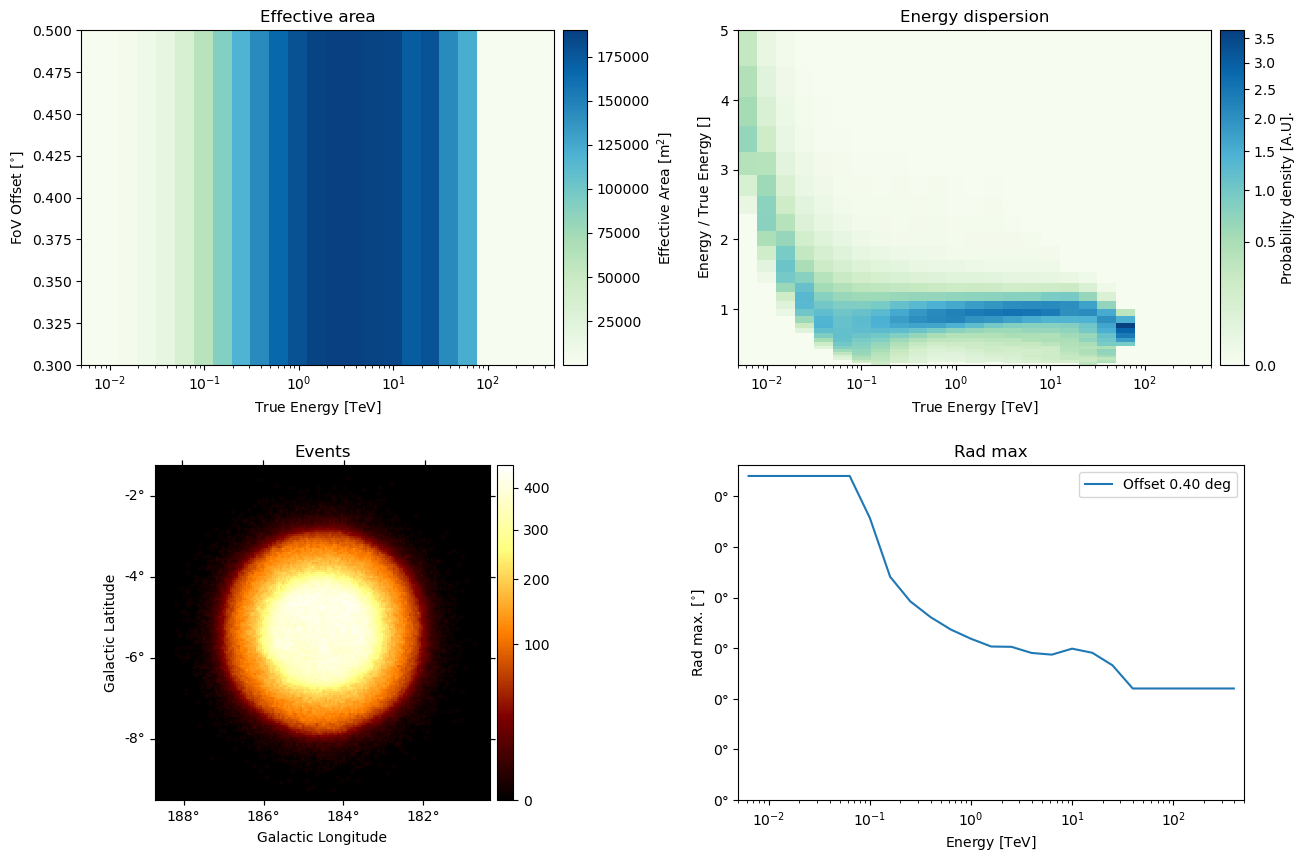

In [21]:
observations[0].peek()

In [22]:
## Create Spectra

In [23]:
target_position = SkyCoord(ra=83.63, dec=22.01, unit="deg", frame="icrs")
on_region = PointSkyRegion(target_position)

In [24]:
# true and estimated energy axes
energy_axis = MapAxis.from_energy_bounds(
    10, 1e5, nbin=10, per_decade=True, unit="GeV", name="energy"
)
energy_axis_true = MapAxis.from_energy_bounds(
    0.1, 1e5, nbin=10, per_decade=True, unit="GeV", name="energy_true"
)

# geometry defining the ON region and SpectrumDataset based on it
geom = RegionGeom.create(region=on_region, axes=[energy_axis])

dataset_empty = SpectrumDataset.create(geom=geom, energy_axis_true=energy_axis_true)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, selection=["counts", "exposure", "edisp"]
)

# tell the background maker to use the WobbleRegionsFinder, let us use 2 off
region_finder = WobbleRegionsFinder(n_off_regions=2)
bkg_maker = ReflectedRegionsBackgroundMaker(region_finder=region_finder)

# use the energy threshold specified in the DL3 files
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

In [25]:
datasets = Datasets()

# create a counts map for visualisation later...
counts = Map.create(skydir=target_position, width=3)

for observation in observations:
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(observation.obs_id)), observation
    )
    counts.fill_events(observation.events)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets.append(dataset_on_off)

## Exercise:
- Play with the number of off regions

/Users/atreyeesinha/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/visualization/datasets.py:84: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  handle = Patch(**plot_kwargs)


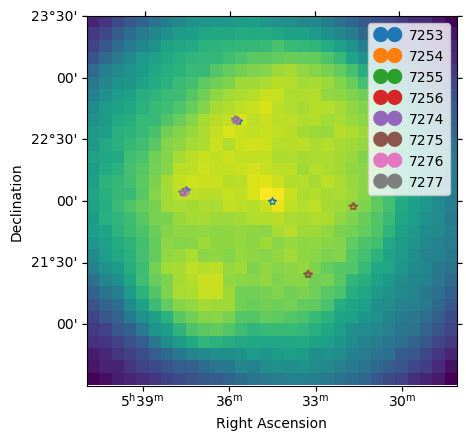

In [26]:
#plot
ax = counts.plot(cmap="viridis")
geom.plot_region(ax=ax, kwargs_point={"color": "k", "marker": "*"})
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets)
plt.show()

In [27]:
# Individual
info_table=datasets.info_table()
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str4,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
7253,15277,332.5,2.209902805007544,14944.5,15055.333333333334,15055.333333333334,nan,298169.9743659423,214466503.36896682,1129.3314335346342,1206.131816163661,13.527472579227988,13.233050596339115,0.29442198288887256,40,33,wstat,379.686629845839,29889,33.0,66.0,0.5
7254,17047,1474.0,9.449196553865805,15573.0,16064.333333333334,16064.333333333334,nan,232167.8517162167,235855673.83391848,1132.919238660023,1207.1603431552653,15.046968414238064,13.745904799374046,1.3010636148640173,40,33,wstat,455.5546412297688,31146,33.0,66.0,0.5
7255,9389,720.5,6.205823011054513,8668.5,8908.666666666666,8908.666666666666,nan,111491.0841802482,213574533.72935575,893.1578297307483,950.1975491046888,10.512139834043007,9.705451501906678,0.8066883321363283,40,32,wstat,309.718459287105,17337,32.0,64.0,0.5
7256,5074,360.0,4.210804513793268,4714.0,4834.0,4834.0,nan,42327.28820944522,114218415.7009537,458.52854386416146,486.65980243682657,11.065832362888115,10.280712211007996,0.7851201518801184,40,32,wstat,179.8967778536584,9428,32.0,64.0,0.5
7274,11095,431.5,3.3816564938425824,10663.5,10807.333333333334,10807.333333333334,nan,180142.39891753622,149586643.60024866,760.2428239437422,812.2123973220589,14.594021344976257,14.02643953241589,0.5675818125603654,40,33,wstat,344.9048167988844,21327,33.0,66.0,0.5
7275,12800,1100.0,8.13656366425411,11700.0,12066.666666666666,12066.666666666666,nan,110977.70250640524,281057505.1134779,1132.649091946265,1204.3772201538136,11.300940504004975,10.329765929442047,0.9711745745629276,40,32,wstat,428.30330523066715,23400,32.0,64.0,0.5
7276,4526,360.0,4.469699078143401,4166.0,4286.0,4286.0,nan,26627.422798688433,99978633.86877179,382.8165654654593,405.96206356585185,11.8228948491216,10.88249667287684,0.9403981762447582,40,32,wstat,218.7345399113777,8332,32.0,64.0,0.5
7277,6829,642.5,6.52226356563296,6186.5,6400.666666666667,6400.666666666667,nan,40790.82285963576,248691690.9193349,882.2682616444946,931.7711615413394,7.740276168691774,7.012039613063648,0.7282365556281248,40,31,wstat,325.71356594109136,12373,31.0,62.0,0.5


In [28]:
# Cumulative
info_table= datasets.info_table(cumulative=True)
info_table

name,counts,excess,sqrt_ts,background,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str7,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,int64,float64,float64,float64
stacked,15277,332.5,2.209902805007544,14944.5,15055.333333333334,15055.333333333334,nan,298169.96875,214466496.0,1129.3314335346342,1206.131816163661,13.527472579227988,13.233050596339115,0.29442198288887256,40,33,wstat,379.686629845839,29889,33.0,66.0,0.5
stacked,32324,1806.5,8.335081914483018,30517.5,31119.666666666664,31119.666666666664,nan,530337.8125,450007584.0,2262.2506721946575,2413.292159318926,14.288425415138368,13.489884377134176,0.7985410380041907,40,33,wstat,787.0800624903204,61035,33.0,66.0,0.5
stacked,41713,2527.0,10.27767173945292,39186.0,40028.33333333333,40028.33333333333,nan,641828.875,659744512.0,3155.4085019254057,3363.489708423615,13.219524500408442,12.41867732057165,0.8008471798367927,40,33,wstat,1080.2845628092425,78372,33.0,66.0,0.5
stacked,46787,2887.0,11.090503241445557,43900.0,44862.33333333333,44862.33333333333,nan,684156.1875,772976064.0,3613.937045789567,3850.1495108604413,12.946268683487277,12.147416915063832,0.7988517684234461,40,33,wstat,1230.186237052394,87800,33.0,66.0,0.5
stacked,57882,3318.5,11.446854479990787,54563.5,55669.666666666664,55669.666666666664,nan,864298.625,922007104.0,4374.179869733309,4662.3619081825,13.23265199963737,12.473995497429488,0.7586565022078817,40,33,wstat,1547.5233400300503,109127,33.0,66.0,0.5
stacked,70682,4418.5,13.813044533997134,66263.5,67736.33333333333,67736.33333333333,nan,975276.3125,1200304640.0,5506.828961679574,5866.739128336314,12.835335996787906,12.032968603366562,0.802367393421343,40,33,wstat,1943.2798345139836,132527,33.0,66.0,0.5
stacked,75208,4778.5,14.486317093419254,70429.5,72022.33333333333,72022.33333333333,nan,1001903.75,1299763584.0,5889.645527145033,6272.701191902166,12.769529108903194,11.958189958189255,0.8113391507139389,40,33,wstat,2144.911154904903,140859,33.0,66.0,0.5
stacked,82037,5421.0,15.746882521049258,76616.0,78423.0,78423.0,nan,1042694.5625,1546434944.0,6771.913788789528,7204.472353443505,12.114300707106908,11.313788448818253,0.800512258288657,40,33,wstat,2451.4142035700115,153232,33.0,66.0,0.5


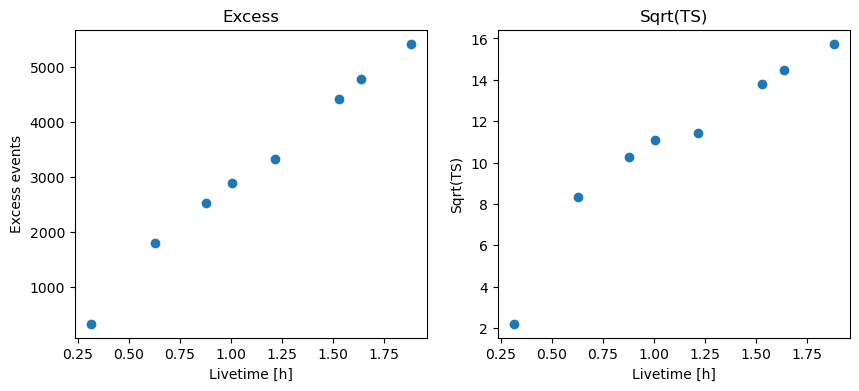

In [29]:


fig, (ax_excess, ax_sqrt_ts) = plt.subplots(figsize=(10, 4), ncols=2, nrows=1)
ax_excess.plot(
    info_table["livetime"].to("h"),
    info_table["excess"],
    marker="o",
    ls="none",
)

ax_excess.set_title("Excess")
ax_excess.set_xlabel("Livetime [h]")
ax_excess.set_ylabel("Excess events")

ax_sqrt_ts.plot(
    info_table["livetime"].to("h"),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)

ax_sqrt_ts.set_title("Sqrt(TS)")
ax_sqrt_ts.set_xlabel("Livetime [h]")
ax_sqrt_ts.set_ylabel("Sqrt(TS)")
plt.show()

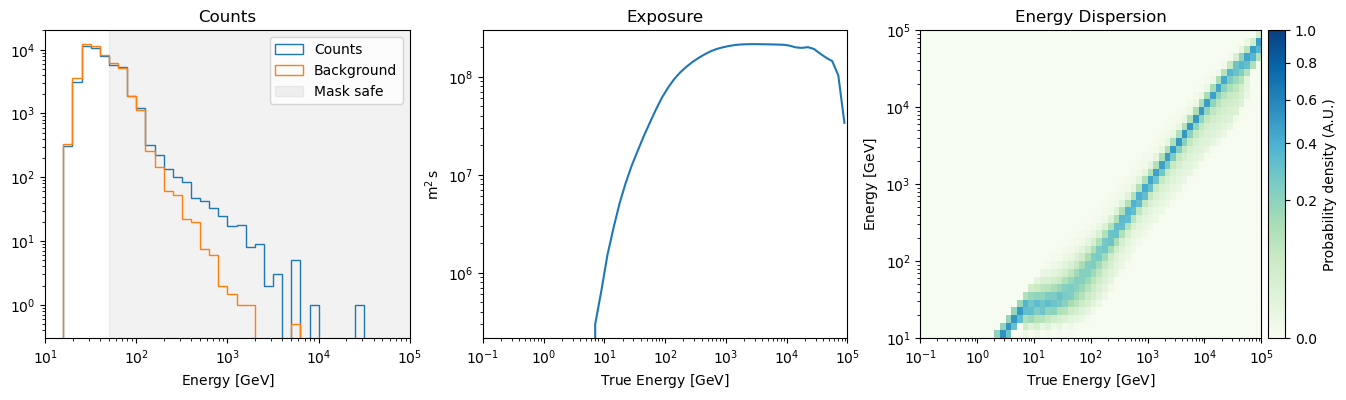

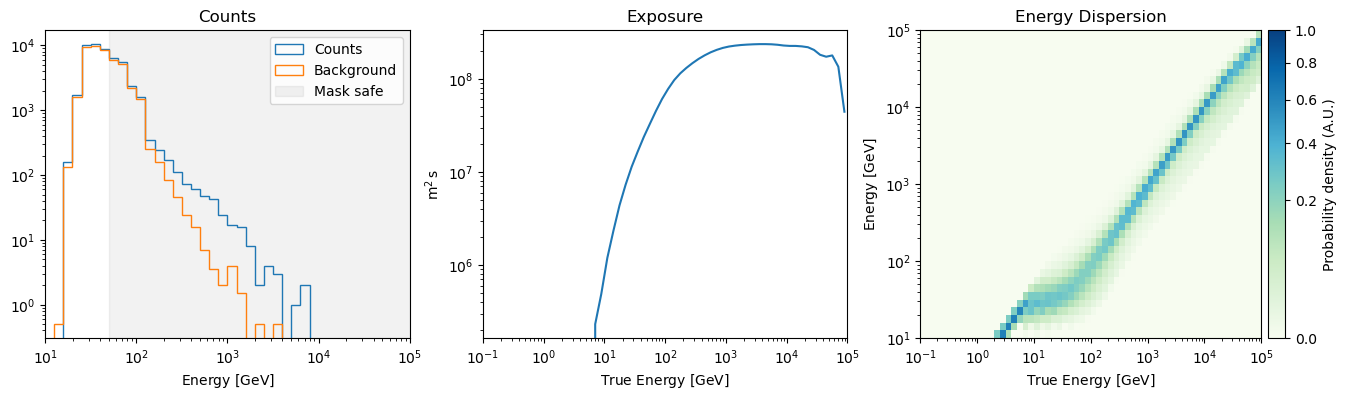

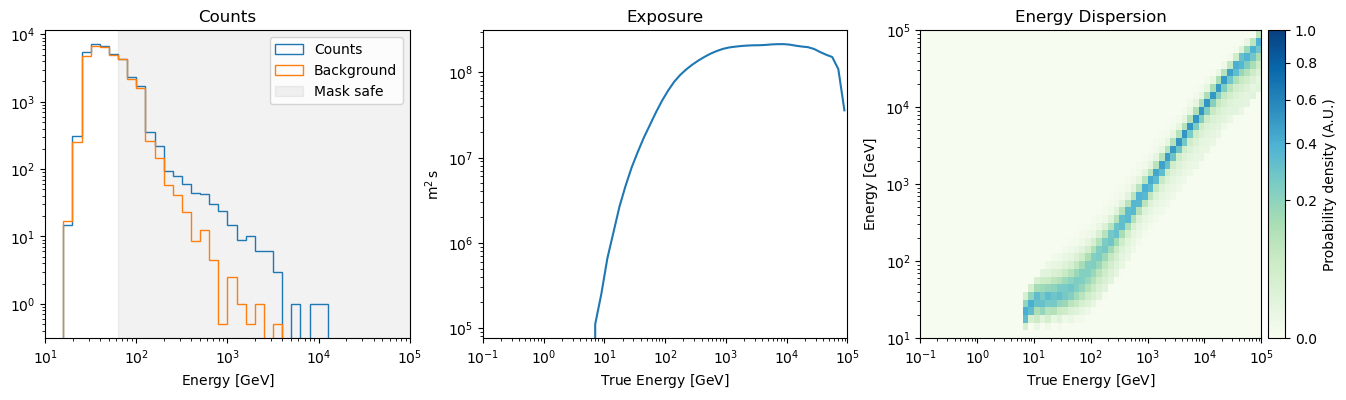

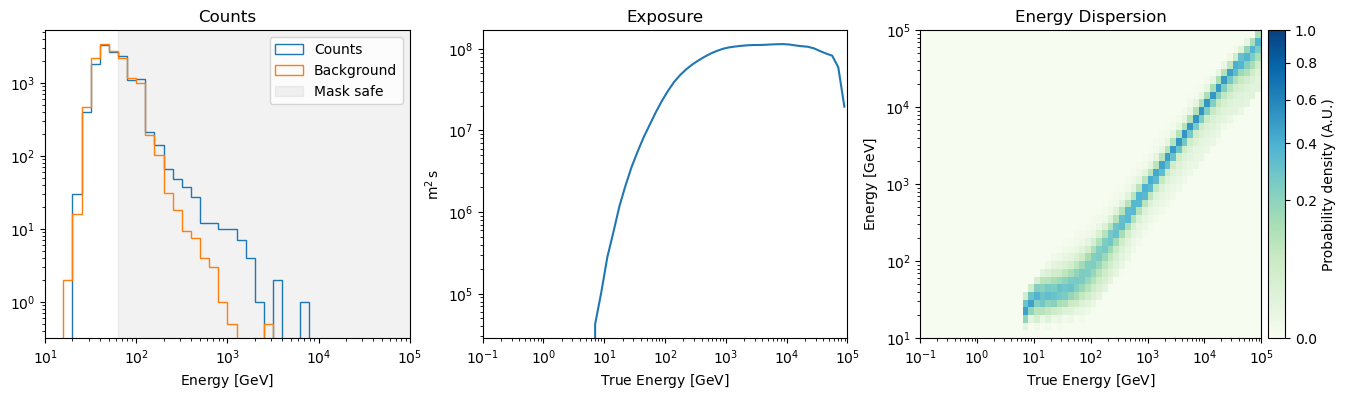

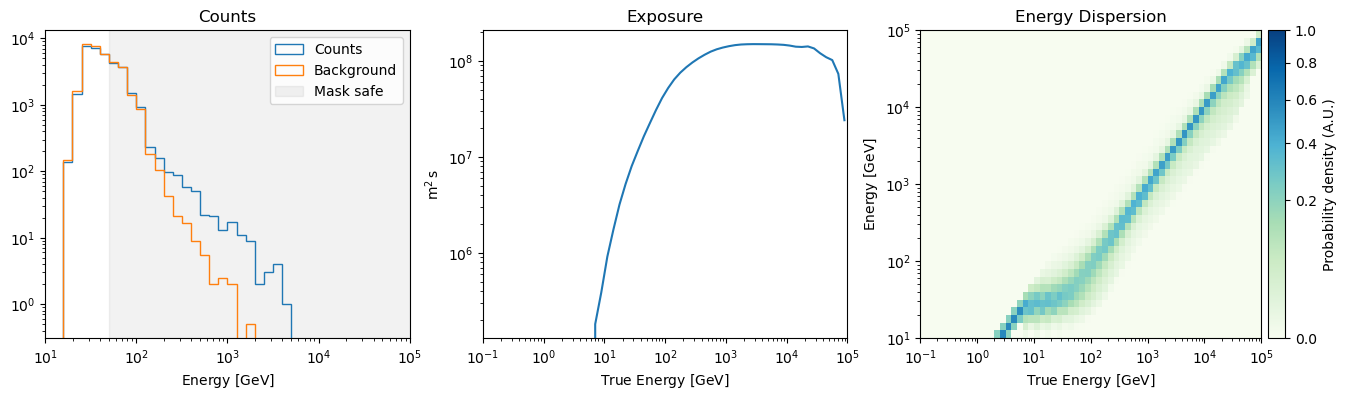

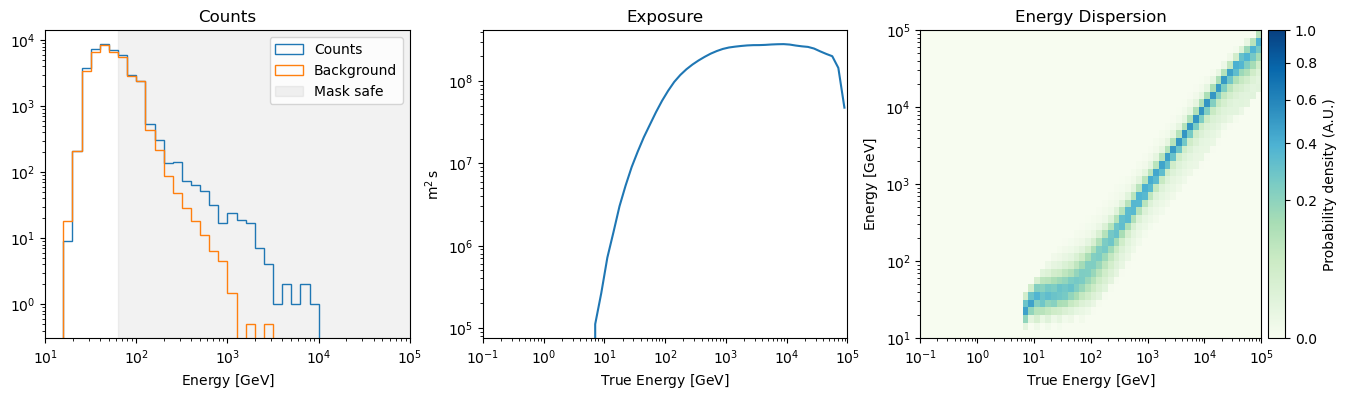

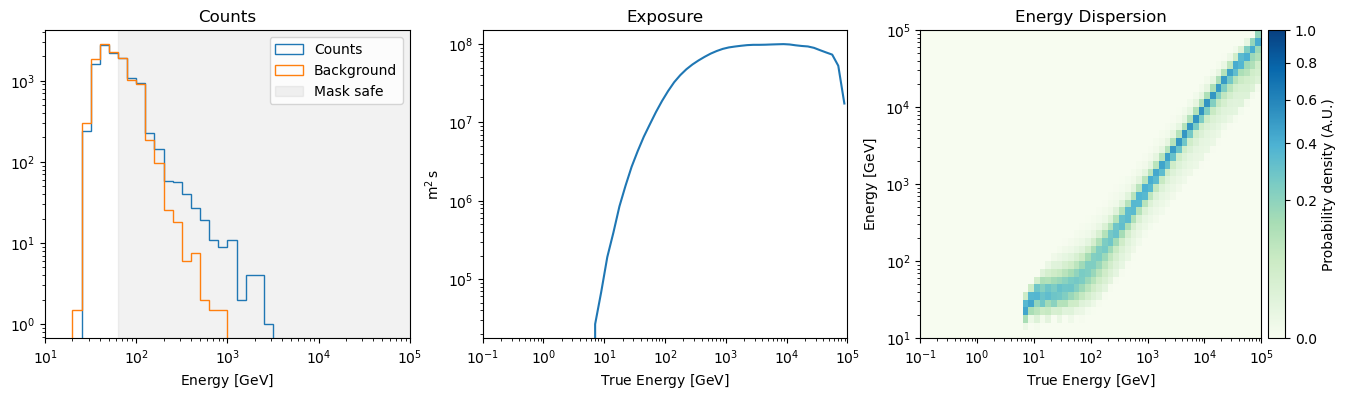

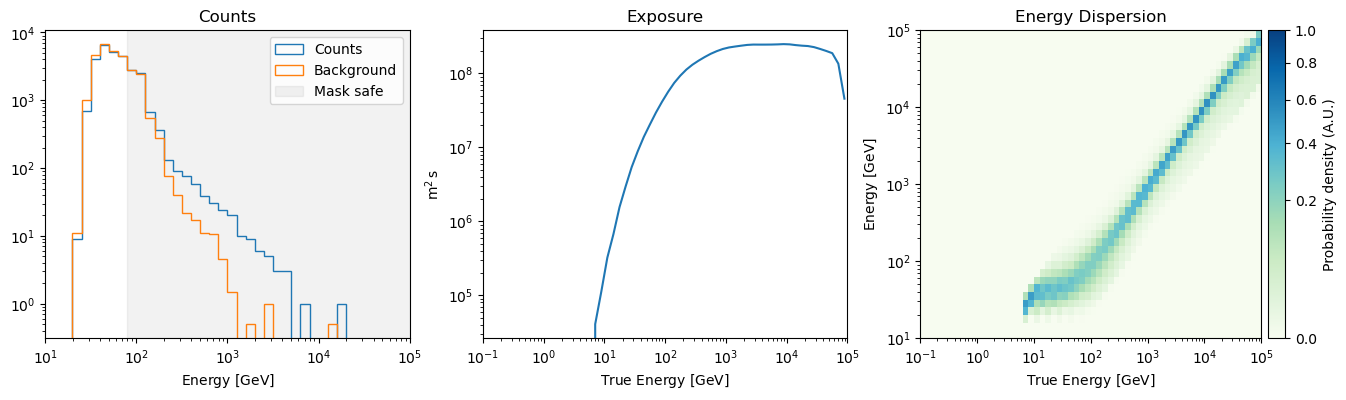

In [30]:
for d in datasets:
    
    fig= d.peek()
    plt.plot()

## Now Fit
- We use a simple power law

In [31]:
e_min = 80 * u.GeV
e_max = 20 * u.TeV

for dataset in datasets:
    dataset.mask_fit = dataset.counts.geom.energy_mask(e_min, e_max)

spectral_model = PowerLawSpectralModel()
model = SkyModel(spectral_model=spectral_model, name="crab")

datasets.models = [model]

fit = Fit()
result = fit.run(datasets=datasets)

# we make a copy here to compare it later
best_fit_model = model.copy()

In [32]:
model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
,index,2.3881e+00,,2.614e-02,nan,nan,False,False,,
,amplitude,3.8267e-11,TeV-1 s-1 cm-2,1.166e-12,nan,nan,False,True,,
,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,


In [33]:
datasets.stat_sum()

209.12458344625526

In [34]:
energy_edges=MapAxis.from_energy_bounds(e_min, e_max, nbin=5, per_decade=True).edges
fpe = FluxPointsEstimator(
    energy_edges=energy_edges, source="crab", selection_optional="all"
)
flux_points = fpe.run(datasets=datasets)

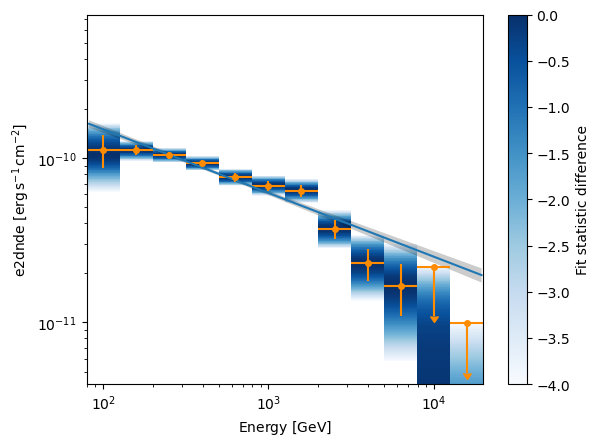

In [35]:
fig, ax = plt.subplots()
sed_type="e2dnde"
flux_points.plot(ax=ax, sed_type=sed_type, color="darkorange")
flux_points.plot_ts_profiles(ax=ax, sed_type=sed_type)
model.spectral_model.plot(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type)
model.spectral_model.plot_error(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type)
plt.show()

## Use another model

In [63]:
spectral2 = LogParabolaSpectralModel()
spectral2.amplitude.value = 4e-11
spectral2.reference.value =  1.0

In [64]:
model_crab = SkyModel(spectral_model=spectral2, name="crab-lp")
model_crab.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
,amplitude,4.0000e-11,TeV-1 s-1 cm-2,0.000e+00,nan,nan,False,True,,
,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
,alpha,2.0000e+00,,0.000e+00,nan,nan,False,False,,
,beta,1.0000e+00,,0.000e+00,nan,nan,False,False,,


In [65]:
datasets.models = model_crab

In [66]:
result2 = fit.run(datasets)

In [67]:
result2.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
,amplitude,4.2618e-11,TeV-1 s-1 cm-2,1.528e-12,nan,nan,False,True,,
,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
,alpha,2.4897e+00,,3.902e-02,nan,nan,False,False,,
,beta,1.4207e-01,,2.891e-02,nan,nan,False,False,,


In [68]:
datasets.stat_sum()

177.16589062013563

We can see there is a significant change in the likelihood.
Since we are comparing nested models, we can directly do a likelihood ratio test

In [74]:
del_TS = 209.124 - datasets.stat_sum()
del_TS

31.958109379864368

In [75]:
from gammapy.stats.utils import ts_to_sigma

In [76]:
ts_to_sigma(del_TS)

5.653150394237214

In [79]:
fpe2 = FluxPointsEstimator(
    energy_edges=energy_edges, source="crab-lp", selection_optional="all"
)
flux_points2 = fpe2.run(datasets=datasets)

<Axes: xlabel='Energy [$\\mathrm{GeV}$]', ylabel='e2dnde [$\\mathrm{erg\\,s^{-1}\\,cm^{-2}}$]'>

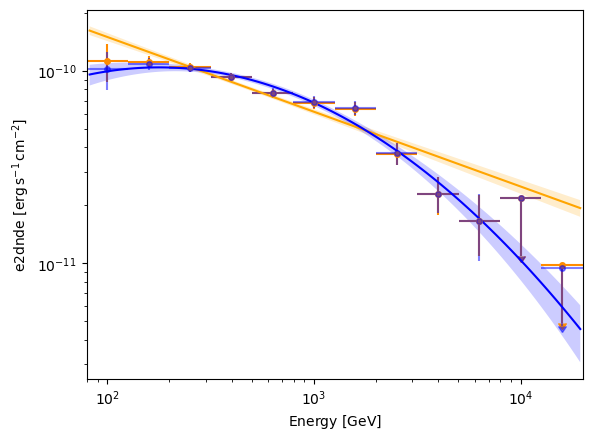

In [80]:
fig, ax = plt.subplots()
sed_type="e2dnde"
flux_points.plot(ax=ax, sed_type=sed_type, color="darkorange")
flux_points2.plot(ax=ax, sed_type=sed_type, color="blue", alpha=0.5)
model.spectral_model.plot(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type, color="orange")
model.spectral_model.plot_error(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type, facecolor="orange")

model_crab.spectral_model.plot(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type, color="blue")
model_crab.spectral_model.plot_error(ax=ax, energy_bounds=(e_min, e_max), sed_type=sed_type, facecolor="blue")